In [1970]:
import json 
import numpy as np
import math
import random 
class Field:
    def __init__(self, field):
        self.field = figures
        self.w_width = self.field['main_rectangle'][0][0]
        self.w_length = self.field['main_rectangle'][0][1]
    def __init(self, path):
        with open(path, "r") as f:
            self.field = json.loads(f.read())
        self.w_width = self.field['main_rectangle'][0][0]
        self.w_length = self.field['main_rectangle'][0][1]

In [2164]:
class Robot(Field):
    def __init__(self, x = 1, y = 0.5, yaw = 0):
 
        self.x = x          # robot's x coordinate
        self.y = y          # robot's y coordinate
        self.orientation = yaw  # robot's orientation
         
        self.forward_noise = 0.05   # noise of the forward movement
        self.turn_noise = 0.1      # noise of the turn
        self.sense_noise = 1   # noise of the sensing
        
    def set_coord(self, new_x, new_y, new_orientation):
        #if new_orientation < 0 or new_orientation >= 2 * pi:
        #   raise ValueError('Orientation must be in [0..2pi]')

        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation)
        
    def set_noise(self, new_forward_noise, new_turn_noise, new_sense_noise):
 
        self.forward_noise = float(new_forward_noise)
        self.turn_noise = float(new_turn_noise)
        self.sense_noise = float(new_sense_noise)  
    
    def sense(self, landmarks):
        z = []
        for i in range(len(landmarks)):
            dist = math.sqrt((self.x - landmarks[i][0]) ** 2 
                             + (self.y - landmarks[i][1]) ** 2)
            dist += random.gauss(0.0, self.sense_noise)
            z.append(dist)
        #print("z = ", z)
        return z
    
    
    def move(self, x, y, yaw):
        # turn, and add randomness to the turning command
        orientation = self.orientation + float(yaw) + random.gauss(0.0, self.turn_noise)
        orientation %= 2 * math.pi

        # move, and add randomness to the motion command
        x = self.x + x + random.gauss(0, self.forward_noise)
        y = self.y + y + random.gauss(0, self.forward_noise)
        #x = math.copysign(Field.w_width, x) if math.fabs(x) >= Field.w_width
        if math.fabs(x) >= field.w_width:
            x = math.copysign(field.w_width/2.0, x)
        if math.fabs(y) >= field.w_length:
            y = math.copysign(field.w_length/2.0, y)
        # set particle
        self.x = x
        self.y = y
        self.orientation = orientation
        #res.set_noise(self.forward_noise, self.turn_noise, self.sense_noise)

    
    def gaussian(self, x, sigma):
        # calculates the probability of x for 1-dim Gaussian with mean mu and var. sigma
        return math.exp(-(x ** 2) / 2*(sigma ** 2)) / math.sqrt(2.0 * math.pi * (sigma ** 2))
    
    def measurement_prob(self, measurement): #particle weight calculation
        prob = 1.0
        matrix_means_land = []
        for i in range(len(landmarks)):
            dists = []
            for measurment_ in measurement:
                x_posts = self.x + measurment_[0]*math.sin(-self.orientation) + measurment_[1]*math.cos(-self.orientation)
                y_posts = self.y + measurment_[0]*math.cos(-self.orientation) - measurment_[1]*math.sin(-self.orientation)
                dist = math.sqrt((x_posts - landmarks[i][0])**2 + (y_posts - landmarks[i][1])**2)
                dists.append(dist)
                #print(self.x, x_posts, self.y, y_posts, self.orientation/math.pi*180)

            prob *= self.gaussian(min(dists), self.sense_noise)
            #matrix_means_land.append(dists)
            #print(self.gaussian(dist, self.sense_noise, measurement[i]))
            #prob *= self.gaussian(dist, self.sense_noise, math.sqrt(measurement[i][0]**2+measurement[i][1]**2)) 
        #if matrix_means_land[0][0] + matrix_means_land[0][1] < matrix_means_land[1][0] + matrix_means_land[1][1]:
         #   prob *= self.gaussian(matrix_means_land[0][0], self.sense_noise) 
         #   prob *= self.gaussian(matrix_means_land[0][1], self.sense_noise)
        #else:
        #    prob *= self.gaussian(matrix_means_land[1][0], self.sense_noise) 
        #    

            #print(dists)
        #, "yaw = ", self.orientation/math.pi * 180)
        #print("govno x = ", self.x + measurment_[0]*math.cos(-self.orientation) 
                                #  - measurment_[1]*math.sin(-self.orientation) - landmarks[i][0])
        #print("====="*10)
        
        if (abs(self.y) < 0.2 and abs(self.x) < 0.2):
            pass
            #print(prob, dists)
            #print("govno x = ", self.x, "govno y = ", self.y, "yaw = ", self.orientation/math.pi * 180)
        return prob
    
    def update_coord(self, particles):
        x = 0.0
        y = 0.0 
        orientation = 0.0
        for i in range(len(particles)):
            x += particles[i][0].x * particles[i][1]
            y += particles[i][0].y * particles[i][1]
            orientation += particles[i][0].orientation * particles[i][1]
        self.x = x
        self.y = y
        self.orientation = orientation
    
    def return_coord(self):
        return self.x, self.y, self.orientation

In [2179]:
class ParticleFilter():
    def __init__(self, myrobot, field,
                 n = 200, forward_noise = 0.025, 
                 turn_noise = 0.1, sense_noise = 0.1, gauss_noise = 0.4):
        self.forward_noise = forward_noise
        self.turn_noise = turn_noise
        self.sense_noise = sense_noise
        self.gauss_noise = gauss_noise
        self.n = n  # number of particles
        self.myrobot = myrobot
        self.p = [] 
        self.yaw_noise = 0.05
        self.gen_particles() 
            
    def custom_reset(self):
        self.p=[]
        for i in range(self.n):
            x = Robot((random.random()-0.5)*field.w_width, (random.random()-0.5)*field.w_length, random.random()*math.pi*2)
            #x.set_noise(forward_noise, turn_noise, 0)
            self.p.append([x,0])
        self.myrobot.update_coord(self.p)
            
    def gen_particles(self):
        self.p = []
        for i in range(self.n):
            x_coord = self.myrobot.x + random.gauss(0, self.sense_noise)
            y_coord = self.myrobot.y + random.gauss(0, self.sense_noise)
            yaw = self.myrobot.orientation + random.gauss(0, self.yaw_noise)*math.pi
            yaw %= 2 * math.pi
            self.p.append([Robot(x_coord, y_coord, yaw), 0])
            
    def move(self, x, y, yaw):
        
        self.myrobot.move(x, y, yaw)
        #z = self.myrobot.sense(landmarks)

        # now we simulate a robot motion for each of
        # these particles
        for partic in self.p:
            partic[0].move(x, y, yaw)        
            
    def do_n_steps(self, n_steps):
        for i in range(n_steps):
            self.step()
            
    def gen_n_particles_robot(self, n):
        p = []
        for i in range(n):
            x_coord = self.myrobot.x + random.gauss(0, self.sense_noise*3)
            y_coord = self.myrobot.y + random.gauss(0, self.sense_noise*3)
            yaw = self.myrobot.orientation + random.gauss(0, self.yaw_noise*3)*math.pi
            yaw %= 2 * math.pi
            p.append([Robot(x_coord, y_coord, yaw), 0])
        return p
    def gen_n_particles(self, n):
        tmp = []
        for i in range(n):
            x = Robot((random.random()-0.5)*field.w_width, (random.random()-0.5)*field.w_length, random.random()*math.pi*2)
            #x.set_noise(forward_noise, turn_noise, 0)
            tmp.append([x,0])
        return tmp
        
    def resampling(self, measurement, landmarks):
        p_tmp = []
        w = []
        S = 0
        for i in range(self.n):
            #z = get_measurements(landmarks)
            w.append(self.p[i][0].measurement_prob(measurement))
            S += (w[i])
        #print("px =  ",p[i][0].x)
        #print("w ", w )
        for i in range(self.n):
            w[i] = w[i]/S
            #S += w[i]
        index = int(random.random() * self.n)
        beta = 0.0
        mw = max(w)
        #print(mw)
        new_particles = {}
        for i in range(self.n):
            beta += random.random() * 2.0 * mw
            while beta > w[index]:
                beta -= w[index]
                index = (index + 1) % self.n
            if index in new_particles.keys():
                new_particles[index] += 1
            else:
                new_particles[index] = 1
            #p_tmp.append([self.p[index][0],w[index]])
        #print(p_tmp)
        for el in new_particles:
            p_tmp.append([self.p[el][0],w[el]*new_particles[el]])

        S = 0
        for i in range(len(p_tmp)):
            S += p_tmp[i][1]
        for i in range(len(p_tmp)):
            p_tmp[i][1] /= S
        self.myrobot.update_coord(p_tmp)
        new_particles = self.gen_n_particles_robot(self.n - len(p_tmp))
        p_tmp.extend(new_particles)
        self.p = p_tmp





        

In [2180]:
figures = {
    "circles": [
    [3, 4.5, 1]
    ], 
    "lines": [
     [[0, 9], [4.5, 4.5]] 
    ], 
    "points": [
        [0, 0]
    ], 
    "main_rectangle": [
        [6, 9]
    ], 
    "rectangles": [
        [[2, 0], 2, 1],[[2,8],2,1]
    ]
}

In [2181]:
path = "untitled.json"
field = Field(path)

In [2182]:
field.field

{'circles': [[3, 4.5, 1]],
 'lines': [[[0, 9], [4.5, 4.5]]],
 'points': [[0, 0]],
 'main_rectangle': [[6, 9]],
 'rectangles': [[[2, 0], 2, 1], [[2, 8], 2, 1]]}

In [2183]:
import matplotlib.pylab as plt
def visualization(robot, step, p, pr, factor = 7 ):
    
    plt.figure("Robot in the world",figsize=(field.w_width, field.w_length))
    plt.title('Particle filter, step ' + str(step))
 
    # draw coordinate grid for plotting
    grid = [-field.w_width/2.0, field.w_width/2.0, -field.w_length/2.0, field.w_length/2.0]
    ax = plt.axis(grid)
    
    for el in field.field:
        if el == 'circles':
            for circle in field.field['circles']:
                plot_circle = plt.Circle((circle[0], circle[1]), circle[2],linewidth=2, fill=False, edgecolor='#330000')
                plt.gca().add_patch(plot_circle)
        if el == 'lines' :     
            for line in field.field['lines']:
                plot_line = plt.Line2D(line[0], line[1], linewidth=2, linestyle="-", color='#330000')
                plt.gca().add_line(plot_line)
        if el == 'rectangles' :     
            for rectangle in field.field['rectangles']:
                rect = plt.Rectangle(rectangle[0], rectangle[1], rectangle[2], linewidth=2, linestyle="-", fill = False, edgecolor='#330000')
                plt.gca().add_patch(rect)
    '''
    # draw particles
    for ind in range(len(p)):
 
        # particle
        circle = plt.Circle((p[ind][0].x, p[ind][0].y), 1./factor/2, facecolor='#ffb266', edgecolor='#994c00', alpha=0.5)
        plt.gca().add_patch(circle)
 
        # particle's orientation
        arrow = plt.Arrow(p[ind][0].x, p[ind][0].y, 2*math.cos(p[ind][0].orientation)/factor, 2*math.sin(p[ind][0].orientation)/factor, width=1/factor, alpha=1., facecolor='#994c00', edgecolor='#994c00')
        plt.gca().add_patch(arrow)
    '''
    # draw resampled particles
    for ind in range(len(pr)):
 
        # particle
        circle = plt.Circle((pr[ind][0].x, pr[ind][0].y), 1./factor/2, facecolor='#ffb266', edgecolor='#cc0000', alpha=0.5)
        plt.gca().add_patch(circle)
 
        # particle's orientation
        arrow = plt.Arrow(pr[ind][0].x, pr[ind][0].y, 2*math.cos(pr[ind][0].orientation)/factor, math.sin(pr[ind][0].orientation)/factor,width=1/factor, alpha=1., facecolor='#006600', edgecolor='#006600')
        plt.gca().add_patch(arrow)
 

    # robot's location
    circle = plt.Circle((robot.x, robot.y), 1./factor/2, facecolor='#FF66E9', edgecolor='#FF66E9')
    plt.gca().add_patch(circle)
 
    # robot's orientation
    arrow = plt.Arrow(robot.x, robot.y, math.cos(robot.orientation)/factor, math.sin(robot.orientation)/factor, width=1/factor, alpha=0.5, facecolor='#000000', edgecolor='#000000')
    plt.gca().add_patch(arrow)


    #fixed landmarks of known locations2
   
    for lm in landmarks:
        circle = plt.Circle(((lm[0], lm[1])), 
                             1./factor/2, facecolor = '#060C73', edgecolor='#060C73')
        plt.gca().add_patch(circle)
    
 
    plt.savefig("figure_" + str(step) + ".png")
    #plt.close()

In [2203]:
landmarks = [[-1, 4.5],[1,4.5]]

In [2204]:
robot = Robot()
robot.set_coord(0, 0, math.pi/2)
               

In [2205]:
pf = ParticleFilter(robot, field, sense_noise = 0.5, n = 200)

In [2206]:
measurment = [[-1, 4.5], [1, 4.5]]

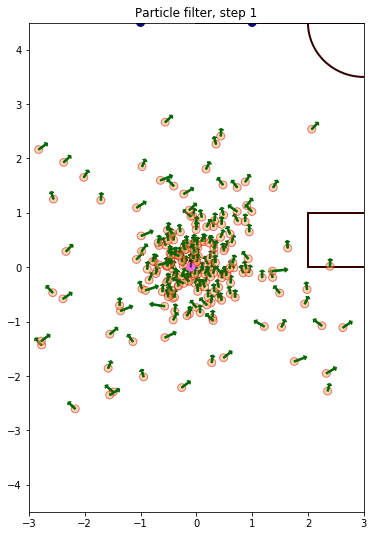

In [2207]:
#pf.custom_reset()
pf.resampling(measurment, landmarks)
visualization(robot, 1, p, pf.p, factor = 7)
#m = max(pf.p, key=lambda tup: tup[1])[0]
#score = max(pf.p, key=lambda tup: tup[1])[1]
#print(m.x,m.y,m.orientation)

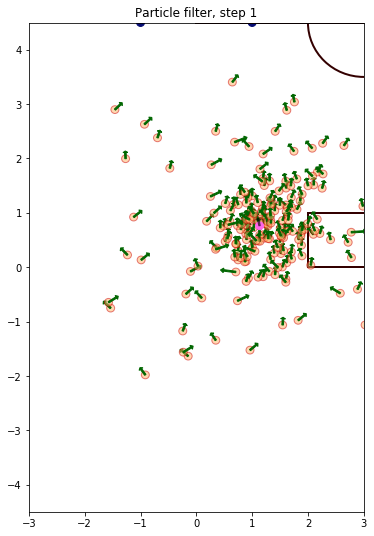

In [2208]:
measurment = [[-2.0,3.5], [0,3.5]]
pf.move(1.3,0.7,0)
visualization(robot, 1, p, pf.p, factor = 7)

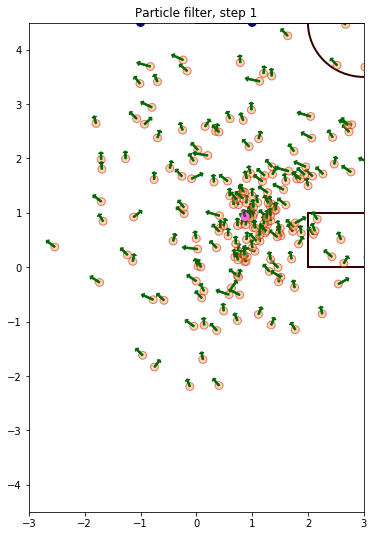

In [2209]:
pf.resampling(measurment, landmarks)
visualization(robot, 1, p, pf.p, factor = 7)

In [34]:
z = [[3.162868755835978, 2.677945044588987],
 [1.665373697724714, 2.1587989303424644]]

In [1948]:
measurement = [[-1,4.5],[1,4.5]]

In [1957]:
x = 1.0 
y = 1.0
orientation = math.pi/2 + 0.5

In [1958]:
measurement_prob(measurement)

1.0354410307910031
1.5811927555563356
prob  2.0009582920794168e-10
x =  1.0 y =  1.0 yaw =  118.64788975654116
govno x =  -2.034997485609286
govno y =  4.469695989902474
[[-1, 4.5], [1, 4.5]]


2.0009582920794168e-10

In [691]:
def measurement_prob(measurement): #particle weight calculation
        prob = 1.0
        for i in range(len(landmarks)):
            dists = []
            for measurment_ in measurement:
                dist = math.sqrt((x + measurment_[0]*math.sin(-orientation) 
                             + measurment_[1]*math.cos(-orientation) - landmarks[i][0]) ** 2 
                             + (y + measurment_[0]*math.cos(-orientation) 
                                  - measurment_[1]*math.sin(-orientation) - landmarks[i][1])** 2 )
                dists.append(dist)
            #print(self.gaussian(dist, self.sense_noise, measurement[i]))
            #prob *= self.gaussian(dist, self.sense_noise, math.sqrt(measurement[i][0]**2+measurement[i][1]**2)) 
            prob *= gaussian(min(dists), 0.4) 
            print(min(dists))
        print("prob ", prob)
        print("x = ", x, "y = ", y, "yaw = ", orientation/math.pi * 180)
        print("govno x = ", x + measurment_[0]*math.sin(-orientation) 
                             + measurment_[1]*math.cos(-orientation) )
        print("govno y = ",  y +  measurment_[0]*math.cos(-orientation) 
                                  - measurment_[1]*math.sin(-orientation))
        print(landmarks)
        print("====="*10)
        return prob
def gaussian(x, sigma):
        # calculates the probability of x for 1-dim Gaussian with mean mu and var. sigma
    return math.exp(-(x ** 2) / (sigma ** 2)) / math.sqrt(2.0 * math.pi * (sigma ** 2))

In [2037]:
measurement

[[-2.0, 3.5], [0, 3.5]]